# S3: QQ Plots

In [1]:
import sys
import socket
print("Working node:", socket.gethostname())
sys.path.append('/workspace/projects/clustering_3d/o3d_analysys/o3d_paper/')
from global_variables import *

Working node: bbgn022


In [2]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import math

In [3]:
def get_all_o3d_gene_result(cohort_df, o3d_output_dir, maf_input_dir, min_n=False):

    lst_df = []
    n_dict = {}
    for cohort in cohort_df["COHORT"].values:
        cohort = "TCGA_WXS_SOFT_TISSUE" if cohort == "TCGA_WXS_SARC" else cohort
        path_csv = f"{o3d_output_dir}/{cohort}/{cohort}.3d_clustering_genes.csv"
        path_input_mut = f"{maf_input_dir}/{cohort}.in.maf"
        if os.path.exists(path_csv):
            df_o3d = pd.read_csv(path_csv, low_memory=False)
            df_o3d = df_o3d[["Gene", "Uniprot_ID", "Cohort", "pval", "qval", "Score_obs_sim_top_vol", "Mut_in_top_vol", "Mut_in_gene"]].dropna(subset=["pval"]).reset_index(drop=True)
            
            df_o3d.pval = df_o3d.pval.replace(0, 0.00001)
            df_mut = pd.read_table(path_input_mut, low_memory=False)
            df_mut = df_mut[df_mut["Variant_Classification"] == "Missense_Mutation"].reset_index(drop=True)
            df_mut = df_mut[df_mut.Hugo_Symbol.isin(df_o3d.Gene.unique())]
            
            if min_n != False:
                if len(df_o3d) > min_n:
                    lst_df.append(df_o3d)
            else:
                lst_df.append(df_o3d)
                
            n_dict[cohort] = {}
            n_dict[cohort]["genes"] = len(df_o3d)
            n_dict[cohort]["mut"] = len(df_mut)
        else:
            print(f"Path doesn't exist: {path_csv}")
            
    df = pd.concat(lst_df)
    df["n_genes"] = df.Cohort.map(lambda x: n_dict[x]["genes"])
    df["n_mut"] = df.Cohort.map(lambda x: n_dict[x]["mut"])
    df = df.sort_values(["n_genes", "pval"], ascending=[False, True])

    return df.reset_index(drop=True)


def qq_plot(df_results, filename, figsize=(10, 16), tcga=True, title_fontsize=12):
    
    cols = 4
    rows = math.ceil(len(df_results.Cohort.unique()) / cols)
    fig, axes = plt.subplots(rows, cols, figsize=figsize, constrained_layout=True)
    axes = axes.flatten()
    
    for i, (cohort, df) in enumerate(df_results.groupby("Cohort", sort=False)):

        # Compute observed p-values and theoretical quantiles
        pvals = -np.log10(df.pval.values)
        n = len(pvals)
        expected = -np.log10(np.linspace(1/n, 1, n))
        ax = axes[i]
        
        # Plot observed vs. theoretical p-values
        ax.scatter(expected, pvals, alpha=0.6)
        x = np.linspace(*ax.get_xlim())
        ax.plot(x, x, color='black', linestyle='--', label='Expected Line (y=x)')

        # Add labels and title for each subplot
        cohort = cohort.replace("TCGA_WXS_SOFT_TISSUE", "TCGA_WXS_SARC")
        cohort_name = cohort.split("_")[len(cohort.split("_"))-1] if tcga else cohort
        ax.set_title(f'{cohort_name}\nN genes = {df["n_genes"].unique()[0]}\nN mut = {df["n_mut"].unique()[0]}', fontsize=title_fontsize)
        ax.set_xlabel(None)
        ax.set_ylabel(None)
    
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        
    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    fig.supxlabel(f"Theoretical quantiles\n-log10(p-values)")
    fig.supylabel(f"Observed quantiles\n  -log10(p-values)")
    
    if filename:
        plt.savefig(filename, dpi=600, bbox_inches='tight')
    plt.show()

In [673]:
SUBDIR = "human_mane_raw"
RUN = "run_2024-07-01_16-04-14"

datasets = f"/workspace/projects/clustering_3d/o3d_analysys/datasets/"
input_path = f"{datasets}/input/cancer_202404"
maf_input_dir = f"{input_path}/maf"
o3d_output_dir = f"{datasets}/output/cancer_202404/o3d_output/{SUBDIR}/{RUN}"

cohort_df = pd.read_csv(f"{input_path}/cohorts.tsv", sep="\t")
cohort_df = cohort_df[~cohort_df.COHORT.str.startswith("ICGC")].reset_index(drop=True)

df_results = get_all_o3d_gene_result(cohort_df, o3d_output_dir, maf_input_dir)
df_results = df_results[df_results.Cohort.str.startswith("TCGA")].reset_index(drop=True)
df_results

Path doesn't exist: /workspace/projects/clustering_3d/o3d_analysys/datasets//output/cancer_202404/o3d_output/human_mane_raw/run_2024-07-01_16-04-14/PEDCBIOP_WXS_TALL_REL/PEDCBIOP_WXS_TALL_REL.3d_clustering_genes.csv


,Gene,Uniprot_ID,Cohort,pval,qval,Score_obs_sim_top_vol,Mut_in_top_vol,Mut_in_gene,n_genes,n_mut
0,BRAF,P15056,TCGA_WXS_MEL,0.00001,0.0,154.374330,245.0,269,10058,165420
1,NRAS,P01111,TCGA_WXS_MEL,0.00001,0.0,57.088760,126.0,127,10058,165420
2,MAP2K1,A4QPA9,TCGA_WXS_MEL,0.00001,0.0,8.864405,20.0,27,10058,165420
3,CNOT9,D5MQE1,TCGA_WXS_MEL,0.00001,0.0,7.687517,14.0,15,10058,165420
4,RAC1,A4D2P1,TCGA_WXS_MEL,0.00001,0.0,7.117122,18.0,22,10058,165420
...,...,...,...,...,...,...,...,...,...,...
36091,UBE3C,Q15386,TCGA_WXS_CHRCC,0.04960,1.0,1.719813,2.0,2,7,28
36092,ATP6V0A4,A0A024R791,TCGA_WXS_CHRCC,0.05770,1.0,1.685607,2.0,2,7,28
36093,CREG2,Q8IUH2,TCGA_WXS_CHRCC,0.08770,1.0,1.592002,2.0,2,7,28
36094,GAL3ST3,Q96A11,TCGA_WXS_CHRCC,0.11200,1.0,1.508403,2.0,2,7,28


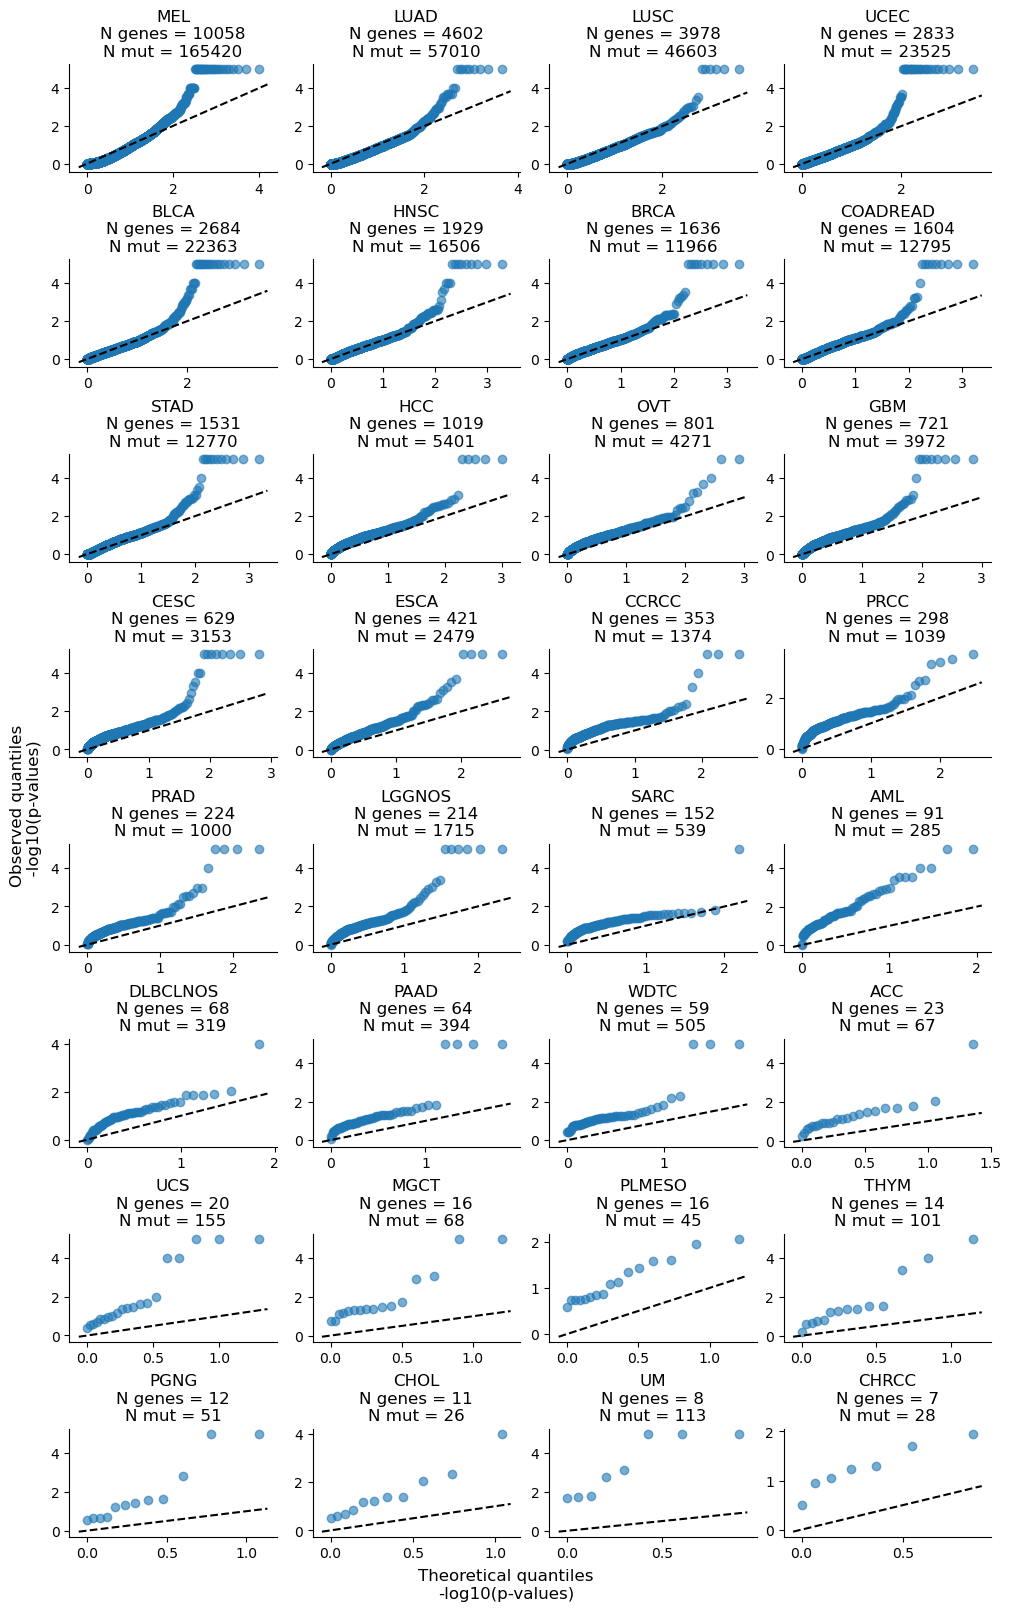

In [5]:
qq_plot(df_results, filename=False)

## Filter by sample size (processed genes)

Path doesn't exist: /workspace/projects/clustering_3d/o3d_analysys/datasets//output/cancer_202404/o3d_output/human_mane_raw/run_2024-07-01_16-04-14/PEDCBIOP_WXS_TALL_REL/PEDCBIOP_WXS_TALL_REL.3d_clustering_genes.csv


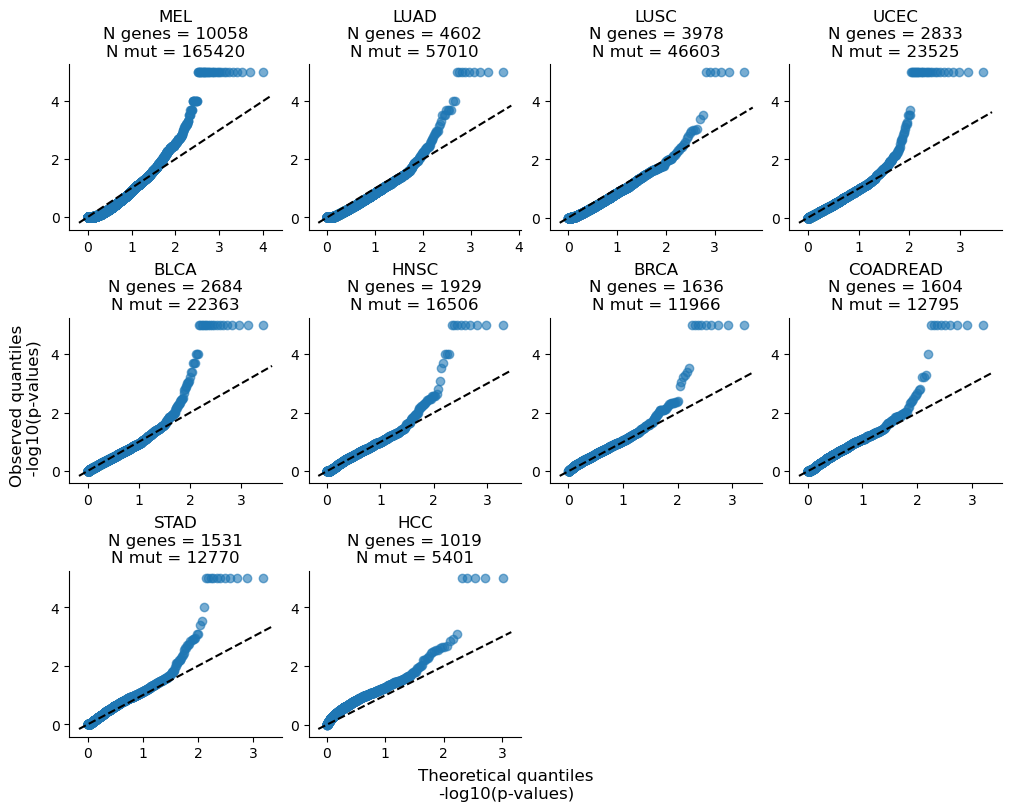

In [6]:
df_results = get_all_o3d_gene_result(cohort_df, o3d_output_dir, maf_input_dir, min_n=1000)
df_results = df_results[df_results.Cohort.str.startswith("TCGA")].reset_index(drop=True)
qq_plot(df_results, filename=False, figsize=(10, 8))

Path doesn't exist: /workspace/projects/clustering_3d/o3d_analysys/datasets//output/cancer_202404/o3d_output/human_mane_raw/run_2024-07-01_16-04-14/PEDCBIOP_WXS_TALL_REL/PEDCBIOP_WXS_TALL_REL.3d_clustering_genes.csv


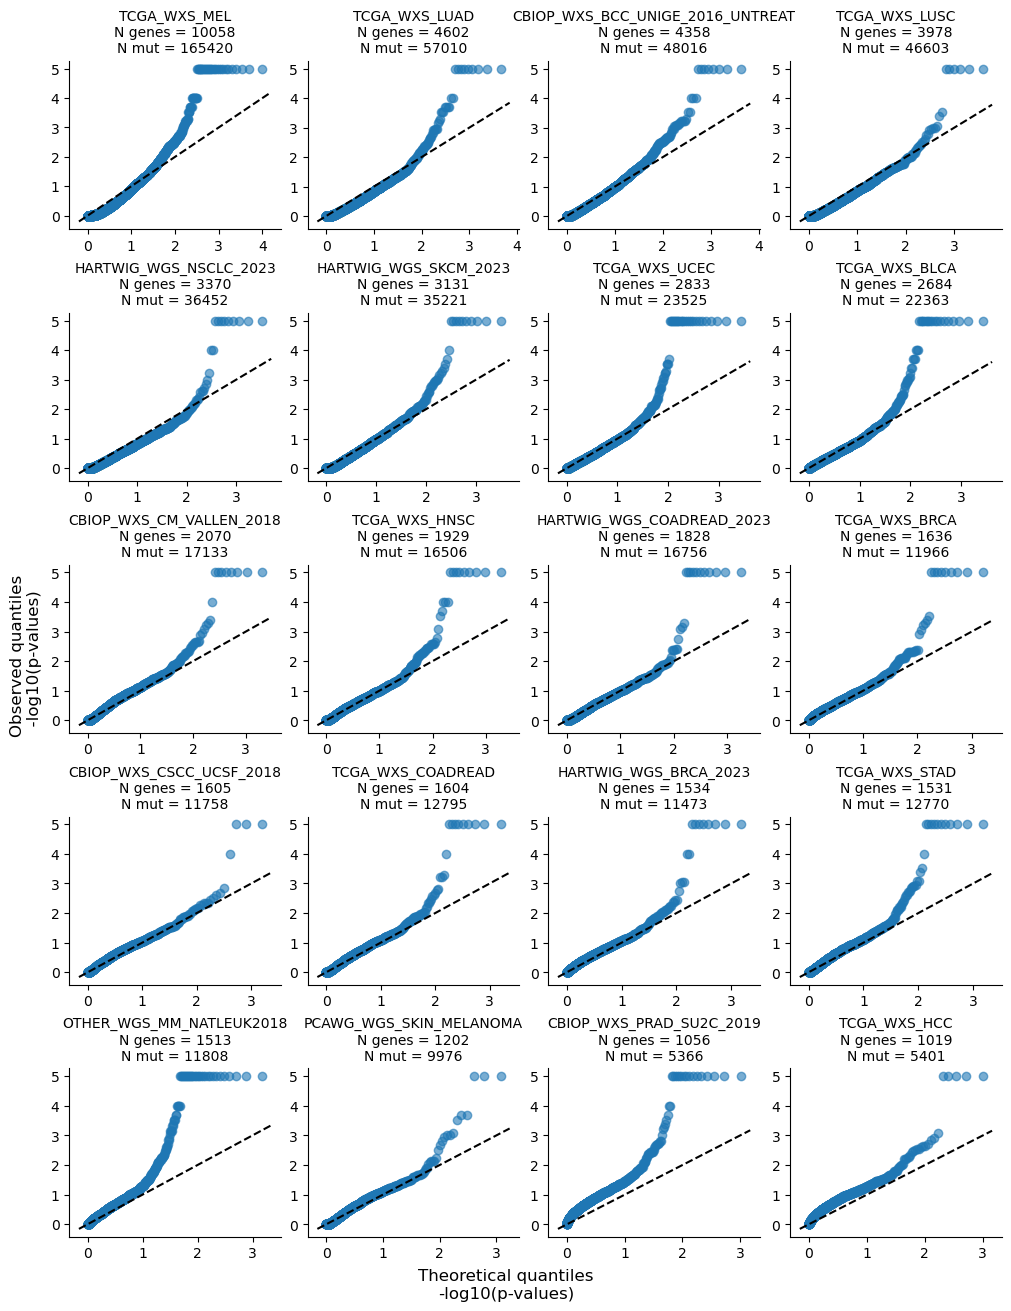

In [7]:
df_results = get_all_o3d_gene_result(cohort_df, o3d_output_dir, maf_input_dir, min_n=1000)
qq_plot(df_results, filename=False, figsize=(10, 13), tcga=False, title_fontsize=10)

## We compute the score at the level of gene-cohort: so a sample size that might affect the score is the number of number of mutations in the gene


Path doesn't exist: /workspace/projects/clustering_3d/o3d_analysys/datasets//output/cancer_202404/o3d_output/human_mane_raw/run_2024-07-01_16-04-14/PEDCBIOP_WXS_TALL_REL/PEDCBIOP_WXS_TALL_REL.3d_clustering_genes.csv


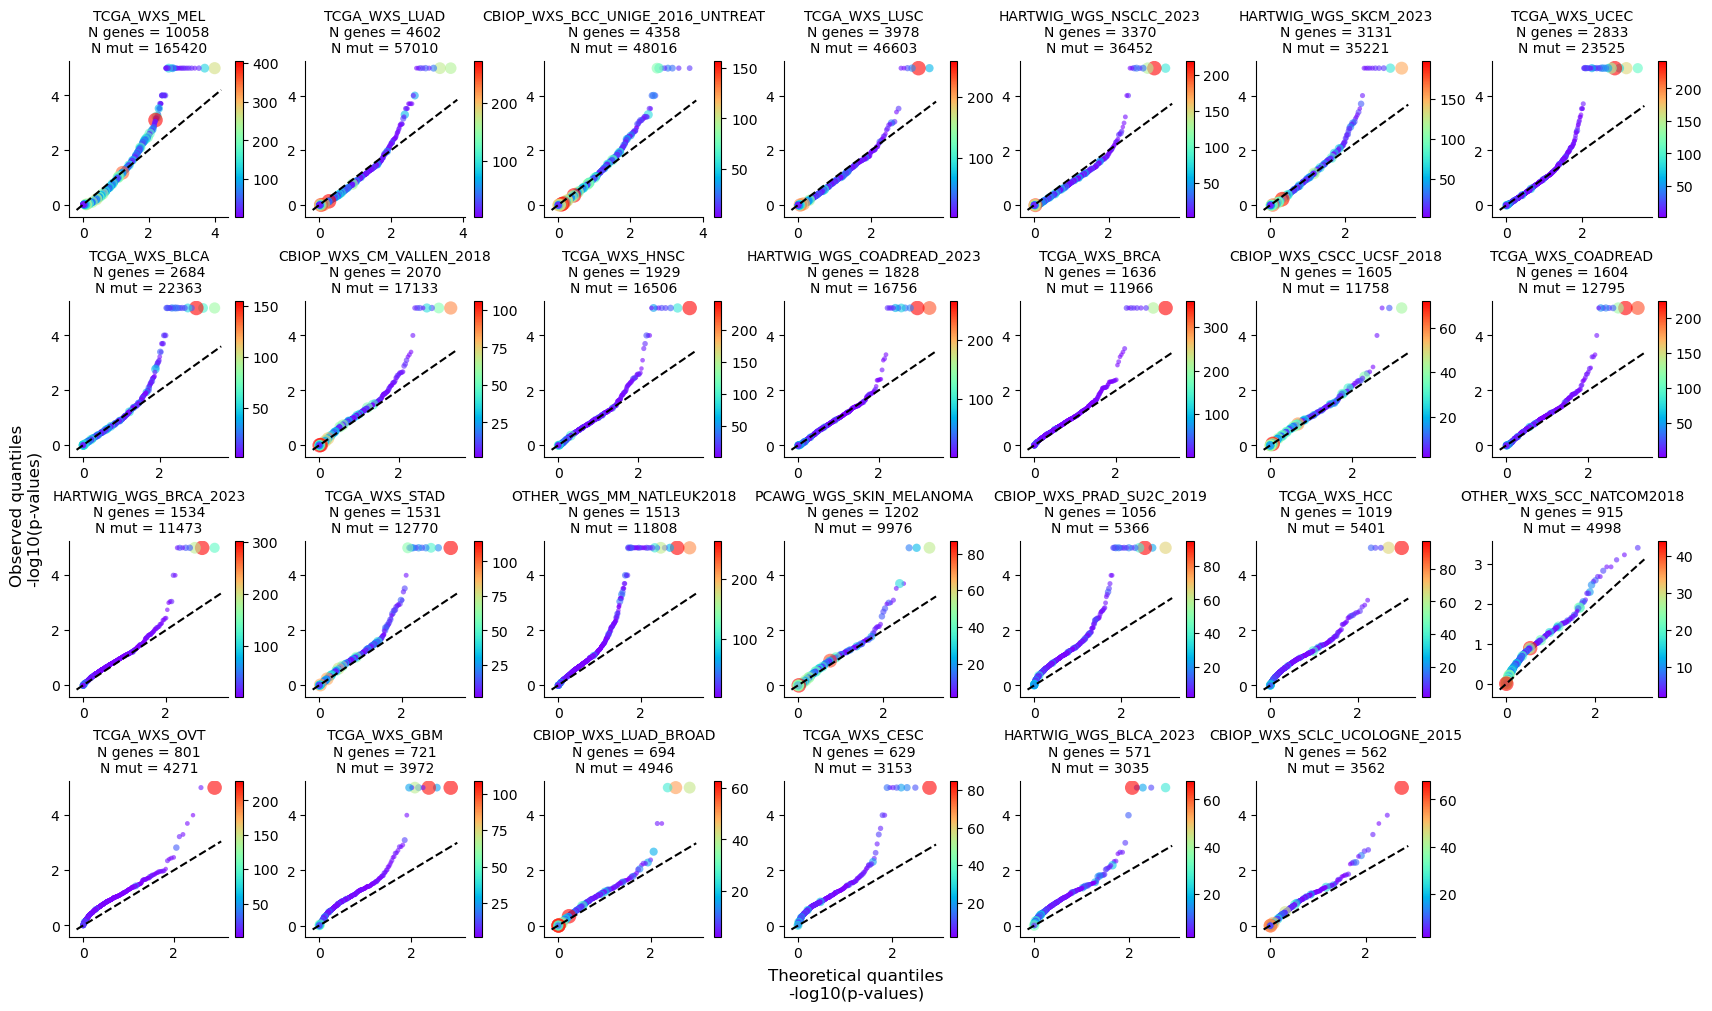

In [658]:
def qq_plot(df_results, filename=None, figsize=(10, 16), tcga=True, title_fontsize=12, cols=4):
    
    rows = math.ceil(len(df_results.Cohort.unique()) / cols)
    fig, axes = plt.subplots(rows, cols, figsize=figsize, constrained_layout=True)
    axes = axes.flatten()

    cmap = plt.cm.rainbow  # Using the rainbow colormap

    for i, (cohort, df) in enumerate(df_results.groupby("Cohort", sort=False)):

        # Compute observed p-values and theoretical quantiles
        pvals = -np.log10(df.pval.values)
        n = len(pvals)
        expected = -np.log10(np.linspace(1/n, 1, n))
        ax = axes[i]
        
        # Normalize colors and sizes based on Mut_in_gene
        norm = plt.Normalize(df["Mut_in_gene"].min(), df["Mut_in_gene"].max())
        size_scale = (df["Mut_in_gene"] - df["Mut_in_gene"].min()) / (df["Mut_in_gene"].max() - df["Mut_in_gene"].min())
        marker_sizes = 10 + (size_scale * 100)  # Scale marker sizes between 10 and 100

        # Scatter plot with size and color based on "Mut_in_gene"
        scatter = ax.scatter(expected, pvals, c=df["Mut_in_gene"], cmap=cmap, norm=norm, s=marker_sizes, alpha=0.6, lw=0)
        
        # Expected line (y=x)
        x = np.linspace(*ax.get_xlim())
        ax.plot(x, x, color='black', linestyle='--', label='Expected Line (y=x)')

        # Add labels and title for each subplot
        cohort = cohort.replace("TCGA_WXS_SOFT_TISSUE", "TCGA_WXS_SARC")
        cohort_name = cohort.split("_")[-1] if tcga else cohort
        ax.set_title(f'{cohort_name}\nN genes = {df["n_genes"].unique()[0]}\nN mut = {df["n_mut"].unique()[0]}', fontsize=title_fontsize)
        ax.set_xlabel(None)
        ax.set_ylabel(None)
    
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)

        # Add color bar next to each subplot
        cbar = fig.colorbar(plt.cm.ScalarMappable(norm=norm, cmap=cmap), ax=ax, orientation='vertical', 
                            fraction=1, pad=0.04)
        # cbar.set_label("Mutations in Gene")

    for j in range(i + 1, len(axes)):
        fig.delaxes(axes[j])

    # Common x and y labels
    fig.supxlabel(f"Theoretical quantiles\n-log10(p-values)")
    fig.supylabel(f"Observed quantiles\n-log10(p-values)")

    # Save the figure if filename is provided
    if filename:
        plt.savefig(filename, dpi=600, bbox_inches='tight')
    plt.show()

df_results = get_all_o3d_gene_result(cohort_df, o3d_output_dir, maf_input_dir, min_n=500)
qq_plot(df_results, filename=False, figsize=(17, 10), tcga=False, title_fontsize=10, cols=7)

Path doesn't exist: /workspace/projects/clustering_3d/o3d_analysys/datasets//output/cancer_202404/o3d_output/human_mane_raw/run_2024-07-01_16-04-14/PEDCBIOP_WXS_TALL_REL/PEDCBIOP_WXS_TALL_REL.3d_clustering_genes.csv


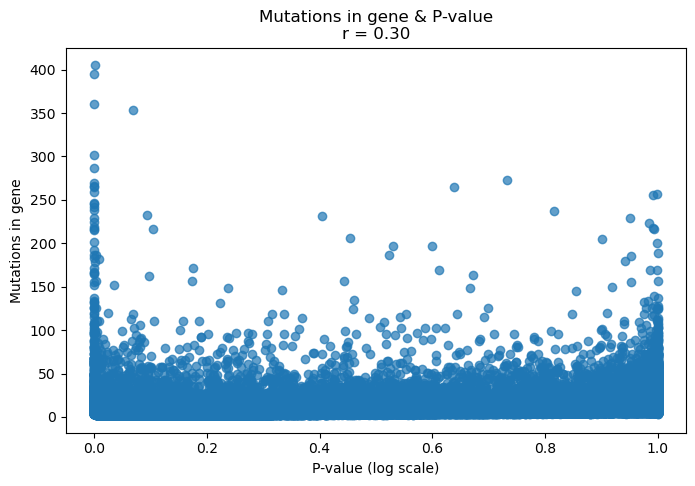

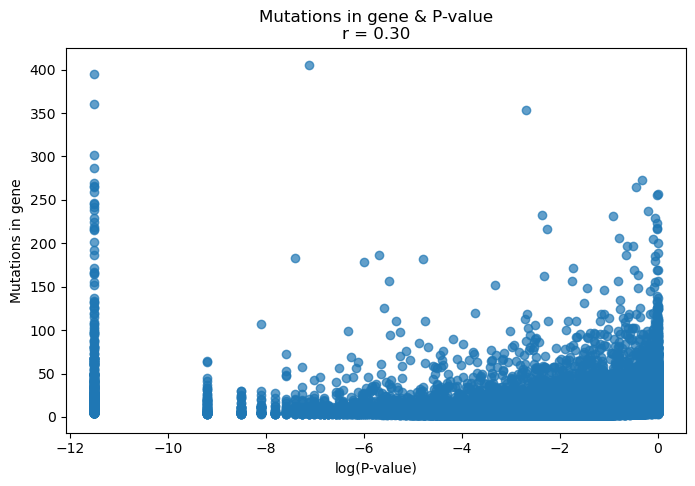

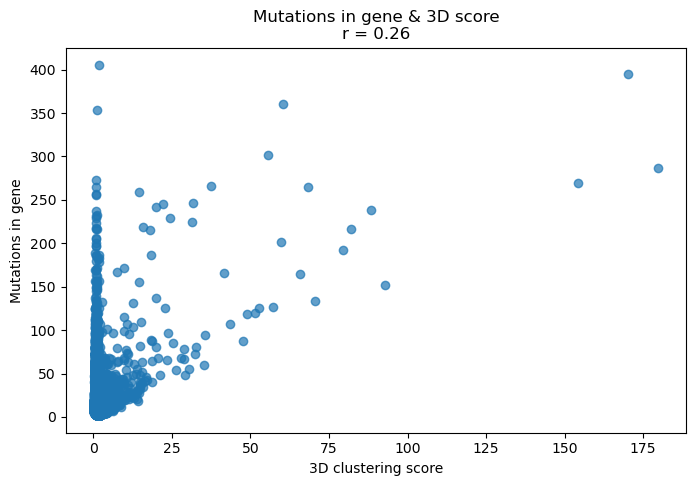

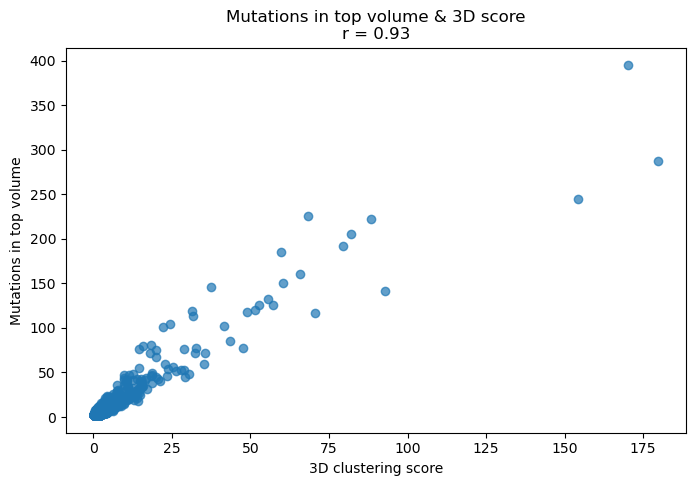

In [659]:
# Associations between N (number of mutations in the gene) and p-value or 3D score

df_results = get_all_o3d_gene_result(cohort_df, o3d_output_dir, maf_input_dir)

# Create DataFrame
df = df_results

plt.figure(figsize=(8, 5))
plt.scatter(df["pval"], df["Mut_in_gene"], alpha=0.7)
plt.xlabel("P-value (log scale)")
plt.ylabel("Mutations in gene")
plt.title(f'Mutations in gene & P-value\nr = {df["pval"].corr(df["Mut_in_gene"]):.2f}')
plt.show()


# Create DataFrame
df = df_results

plt.figure(figsize=(8, 5))
plt.scatter(np.log(df["pval"]), df["Mut_in_gene"], alpha=0.7)
plt.xlabel("log(P-value)")
plt.ylabel("Mutations in gene")
plt.title(f'Mutations in gene & P-value\nr = {df["pval"].corr(df["Mut_in_gene"]):.2f}')
plt.show()


# Create DataFrame
df = df_results

plt.figure(figsize=(8, 5))
plt.scatter(df["Score_obs_sim_top_vol"], df["Mut_in_gene"], alpha=0.7)
plt.xlabel("3D clustering score")
plt.ylabel("Mutations in gene")
plt.title(f'Mutations in gene & 3D score\nr = {df["Score_obs_sim_top_vol"].corr(df["Mut_in_gene"]):.2f}')
plt.show()


# Create DataFrame
df = df_results

plt.figure(figsize=(8, 5))
plt.scatter(df["Score_obs_sim_top_vol"], df["Mut_in_top_vol"], alpha=0.7)
plt.xlabel("3D clustering score")
plt.ylabel("Mutations in top volume")
plt.title(f'Mutations in top volume & 3D score\nr = {df["Score_obs_sim_top_vol"].corr(df["Mut_in_top_vol"]):.2f}')
plt.show()



In [674]:
# Detected genes and score distribution
df_results_norm = get_all_o3d_gene_result(cohort_df, o3d_output_dir, maf_input_dir, min_n=False)
df_results_norm = df_results_norm[df_results_norm["qval"] < 0.01]
print("Detected gene-cancer:", len(df_results_norm))
print("Detected gene:", len(df_results_norm.Gene.unique()))

Path doesn't exist: /workspace/projects/clustering_3d/o3d_analysys/datasets//output/cancer_202404/o3d_output/human_mane_raw/run_2024-07-01_16-04-14/PEDCBIOP_WXS_TALL_REL/PEDCBIOP_WXS_TALL_REL.3d_clustering_genes.csv
Detected gene-cancer: 619
Detected gene: 273


# Not-normalized 3D clustering score

## Oncodrive3D result

In [675]:
SUBDIR = "review"
RUN = "run_notnorm_2025-03-26_10-58-45"

In [676]:
datasets = f"/workspace/projects/clustering_3d/o3d_analysys/datasets/"
input_path = f"{datasets}/input/cancer_202404"
maf_input_dir = f"{input_path}/maf"
o3d_output_dir = f"{datasets}/output/cancer_202404/o3d_output/{SUBDIR}/{RUN}"

cohort_df = pd.read_csv(f"{input_path}/cohorts.tsv", sep="\t")
cohort_df = cohort_df[~cohort_df.COHORT.str.startswith("ICGC")].reset_index(drop=True)

df_results = get_all_o3d_gene_result(cohort_df, o3d_output_dir, maf_input_dir)
df_results = df_results[df_results.Cohort.str.startswith("TCGA")].reset_index(drop=True)
df_results

Path doesn't exist: /workspace/projects/clustering_3d/o3d_analysys/datasets//output/cancer_202404/o3d_output/review/run_notnorm_2025-03-26_10-58-45/PEDCBIOP_WXS_TALL_REL/PEDCBIOP_WXS_TALL_REL.3d_clustering_genes.csv


,Gene,Uniprot_ID,Cohort,pval,qval,Score_obs_sim_top_vol,Mut_in_top_vol,Mut_in_gene,n_genes,n_mut
0,BRAF,P15056,TCGA_WXS_MEL,0.00001,0.0,161.396484,243.0,269,10058,165420
1,NRAS,P01111,TCGA_WXS_MEL,0.00001,0.0,66.875076,122.0,127,10058,165420
2,MAP2K1,A4QPA9,TCGA_WXS_MEL,0.00001,0.0,8.509448,20.0,27,10058,165420
3,RAC1,A4D2P1,TCGA_WXS_MEL,0.00001,0.0,8.464008,18.0,22,10058,165420
4,CNOT9,D5MQE1,TCGA_WXS_MEL,0.00001,0.0,7.297280,14.0,15,10058,165420
...,...,...,...,...,...,...,...,...,...,...
36089,SCAPER,Q9BY12,TCGA_WXS_CHRCC,0.01930,1.0,1.491021,2.0,2,7,28
36090,UBE3C,Q15386,TCGA_WXS_CHRCC,0.04940,1.0,1.517692,2.0,2,7,28
36091,ATP6V0A4,A0A024R791,TCGA_WXS_CHRCC,0.05770,1.0,1.371249,2.0,2,7,28
36092,CREG2,Q8IUH2,TCGA_WXS_CHRCC,0.08770,1.0,1.188918,2.0,2,7,28


In [631]:
path = f"{datasets}/output/cancer_202404/o3d_output/review/{RUN}/TCGA_WXS_BLCA/TCGA_WXS_BLCA.3d_clustering_pos.csv"
df = pd.read_csv(path)
df

,Gene,Uniprot_ID,Pos,Mut_in_gene,Mut_in_res,Mut_in_vol,Score,Score_obs_sim,pval,C,...,Clump,Rank,Mut_in_cl_vol,Res_in_cl,PAE_vol,pLDDT_res,pLDDT_vol,pLDDT_cl_vol,Cancer,Cohort
0,AADAT,Q4W5N8,66,4,1,2,4.105037,0.725810,0.8473,0,...,NaN,0,NaN,NaN,0.5,97.56,98.03,NaN,NaN,TCGA_WXS_BLCA
1,AADAT,Q4W5N8,68,4,1,2,3.809423,0.742222,0.8784,0,...,NaN,1,NaN,NaN,0.5,98.50,98.03,NaN,NaN,TCGA_WXS_BLCA
2,AADAT,Q4W5N8,105,4,1,1,2.628673,0.549844,1.0000,0,...,NaN,2,NaN,NaN,0.0,97.38,97.38,NaN,NaN,TCGA_WXS_BLCA
3,AADAT,Q4W5N8,313,4,1,1,2.005367,0.444036,1.0000,0,...,NaN,3,NaN,NaN,0.0,98.12,98.12,NaN,NaN,TCGA_WXS_BLCA
4,AAR2,Q9Y312,237,3,1,2,6.073210,1.154828,0.3088,0,...,NaN,0,NaN,NaN,0.5,96.77,96.34,NaN,NaN,TCGA_WXS_BLCA
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21153,ZZEF1,O43149,736,17,1,1,2.199094,0.409601,1.0000,0,...,NaN,9,NaN,NaN,NaN,94.53,94.53,NaN,NaN,TCGA_WXS_BLCA
21154,ZZEF1,O43149,77,17,1,1,1.998549,0.404507,1.0000,0,...,NaN,13,NaN,NaN,NaN,76.78,76.78,NaN,NaN,TCGA_WXS_BLCA
21155,ZZEF1,O43149,1347,17,1,1,1.921324,0.403404,1.0000,0,...,NaN,15,NaN,NaN,NaN,68.42,68.42,NaN,NaN,TCGA_WXS_BLCA
21156,ZZEF1,O43149,935,17,1,1,1.938244,0.399616,1.0000,0,...,NaN,14,NaN,NaN,NaN,90.86,90.86,NaN,NaN,TCGA_WXS_BLCA


Path doesn't exist: /workspace/projects/clustering_3d/o3d_analysys/datasets//output/cancer_202404/o3d_output/review/run_notnorm_2025-03-26_10-58-45/PEDCBIOP_WXS_TALL_REL/PEDCBIOP_WXS_TALL_REL.3d_clustering_genes.csv


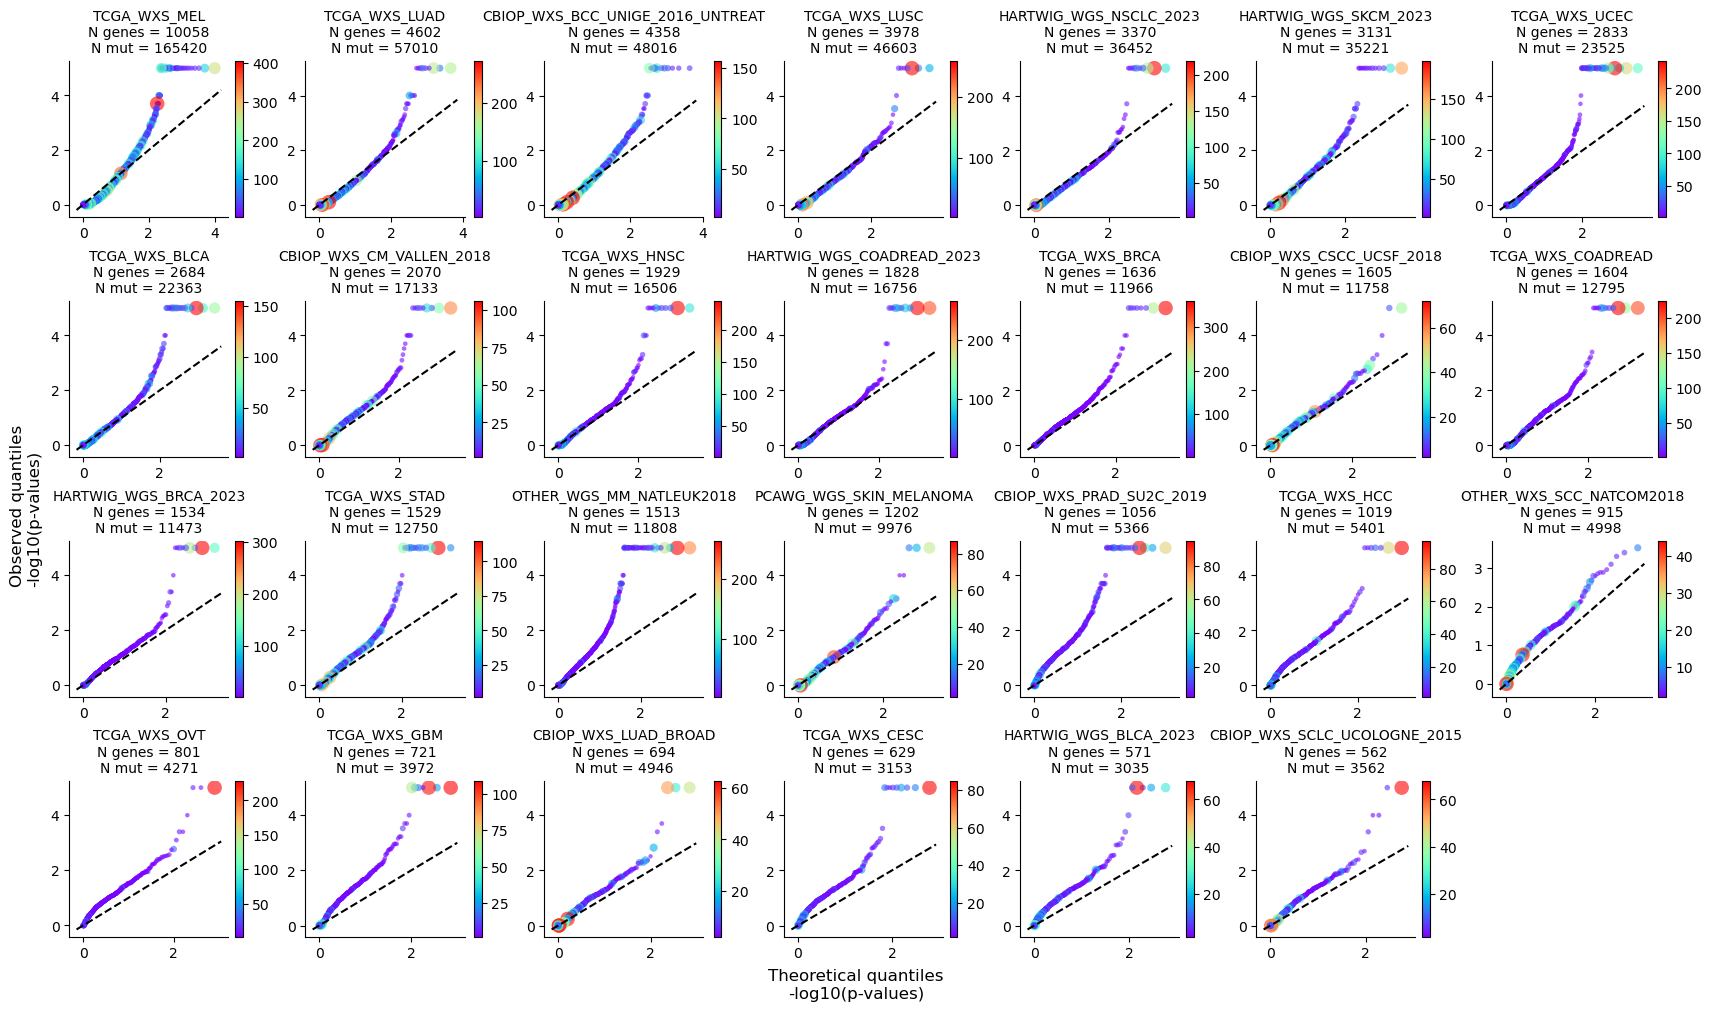

In [632]:
df_results = get_all_o3d_gene_result(cohort_df, o3d_output_dir, maf_input_dir, min_n=500)
qq_plot(df_results, filename=False, figsize=(17, 10), tcga=False, title_fontsize=10, cols=7)

Path doesn't exist: /workspace/projects/clustering_3d/o3d_analysys/datasets//output/cancer_202404/o3d_output/review/run_notnorm_2025-03-26_10-58-45/PEDCBIOP_WXS_TALL_REL/PEDCBIOP_WXS_TALL_REL.3d_clustering_genes.csv


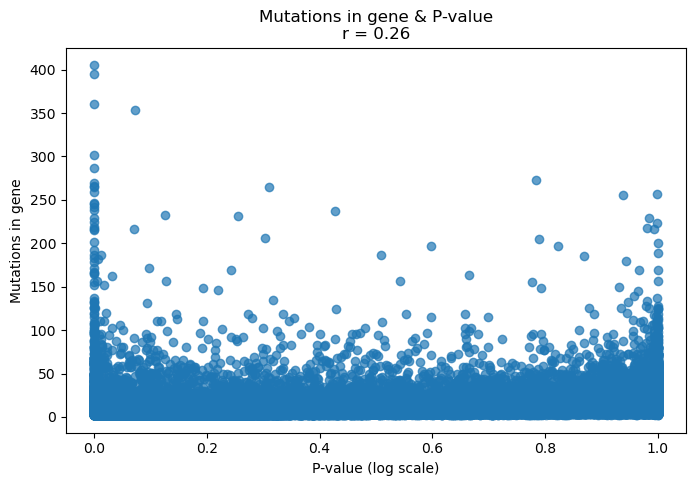

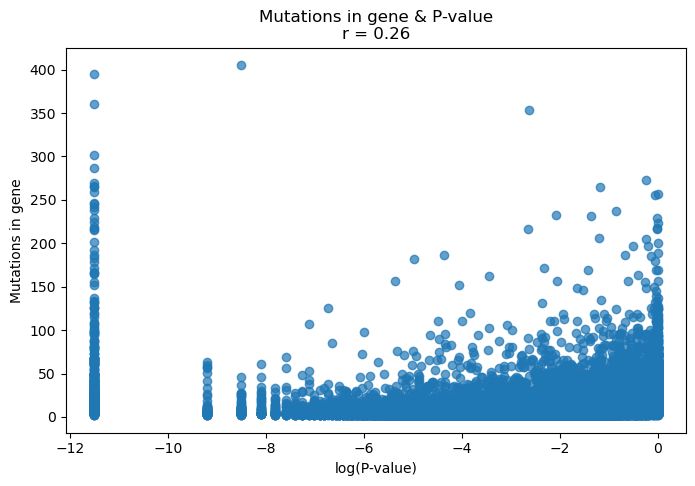

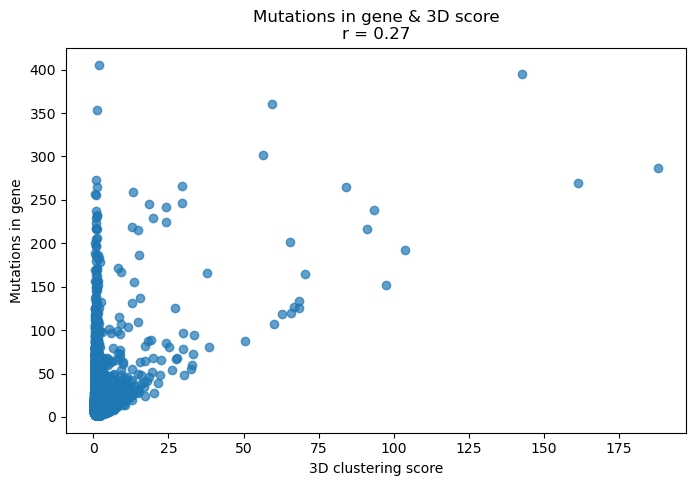

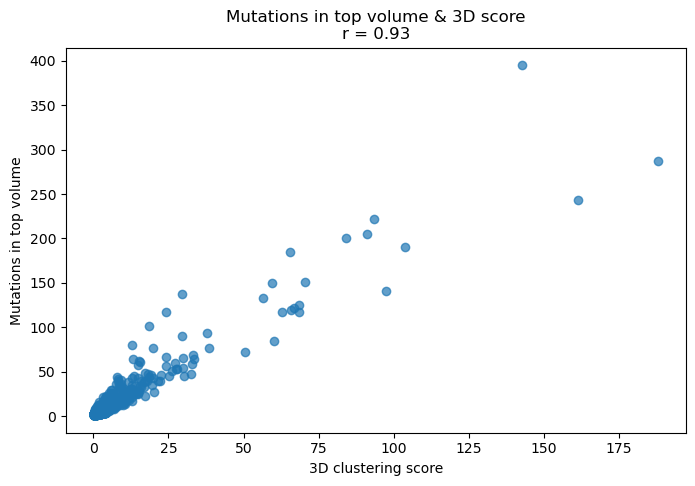

In [633]:
# Associations between N (number of mutations in the gene) and p-value or 3D score

df_results = get_all_o3d_gene_result(cohort_df, o3d_output_dir, maf_input_dir)

# Create DataFrame
df = df_results

plt.figure(figsize=(8, 5))
plt.scatter(df["pval"], df["Mut_in_gene"], alpha=0.7)
plt.xlabel("P-value (log scale)")
plt.ylabel("Mutations in gene")
plt.title(f'Mutations in gene & P-value\nr = {df["pval"].corr(df["Mut_in_gene"]):.2f}')
plt.show()


# Create DataFrame
df = df_results

plt.figure(figsize=(8, 5))
plt.scatter(np.log(df["pval"]), df["Mut_in_gene"], alpha=0.7)
plt.xlabel("log(P-value)")
plt.ylabel("Mutations in gene")
plt.title(f'Mutations in gene & P-value\nr = {df["pval"].corr(df["Mut_in_gene"]):.2f}')
plt.show()


# Create DataFrame
df = df_results

plt.figure(figsize=(8, 5))
plt.scatter(df["Score_obs_sim_top_vol"], df["Mut_in_gene"], alpha=0.7)
plt.xlabel("3D clustering score")
plt.ylabel("Mutations in gene")
plt.title(f'Mutations in gene & 3D score\nr = {df["Score_obs_sim_top_vol"].corr(df["Mut_in_gene"]):.2f}')
plt.show()


# Create DataFrame
df = df_results

plt.figure(figsize=(8, 5))
plt.scatter(df["Score_obs_sim_top_vol"], df["Mut_in_top_vol"], alpha=0.7)
plt.xlabel("3D clustering score")
plt.ylabel("Mutations in top volume")
plt.title(f'Mutations in top volume & 3D score\nr = {df["Score_obs_sim_top_vol"].corr(df["Mut_in_top_vol"]):.2f}')
plt.show()

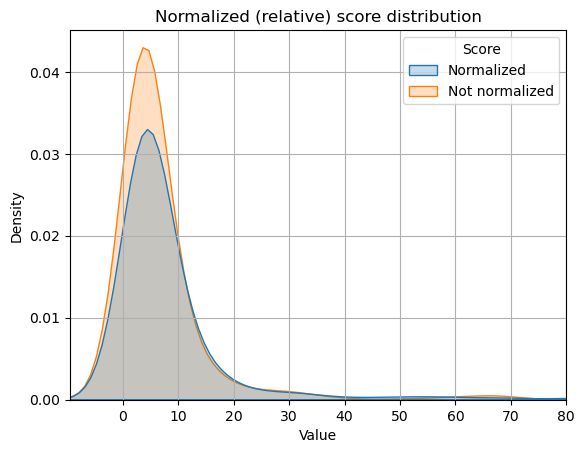

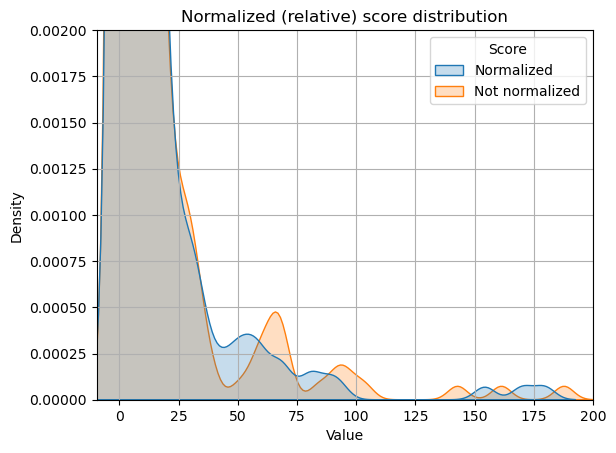

In [705]:
# Score distribution

df_results_norm["Score"] = "Normalized"
df_results_notnorm["Score"] = "Not normalized"
df_results_plot = pd.concat((df_results_norm[["Score", "Score_obs_sim_top_vol"]], df_results_notnorm[["Score", "Score_obs_sim_top_vol"]]))

sns.kdeplot(data = df_results_plot, x="Score_obs_sim_top_vol", fill=True, hue="Score")
plt.title("Normalized (relative) score distribution")
plt.xlabel("Value")
plt.ylabel("Density")
plt.xlim(-9.5, 80)
plt.grid(True)
plt.show()

sns.kdeplot(data = df_results_plot, x="Score_obs_sim_top_vol", fill=True, hue="Score")
plt.title("Normalized (relative) score distribution")
plt.xlabel("Value")
plt.ylabel("Density")
plt.xlim(-9.5, 200)
plt.ylim(0, 0.002)
plt.grid(True)
plt.show()

## Analysis of the 3D clustering score

In [ ]:
from functools import reduce
import operator
from decimal import Decimal, getcontext
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np


def dcm_factorial(n):
    """
    Compute factorial.
    """
    return reduce(operator.mul, [Decimal(i) for i in range(1, int(n)+1)], Decimal(1))


def dcm_binom_coeff(n, k):
    """
    Compute binomial coefficient.
    """
    
    return dcm_factorial(n) / (dcm_factorial(k) * dcm_factorial(n - k))


def dcm_binom_cdf(k, n, p):
    """
    Compute binomial cumulative distribution function (CDF).
    """
    
    p = Decimal(p)
    q = Decimal(1) - p
    cdf = Decimal(0)
    for i in range(int(k) + 1):
        cdf += dcm_binom_coeff(n, i) * (p ** i) * (q ** (n - i))
        
    return cdf


def dcm_binom_sf(k, n, p):
    """
    Compute binomial survival function (SF).
    """
    
    return Decimal('1') - dcm_binom_cdf(k, n, p)


def dcm_binom_logsf(k, n, p):
    """
    Compute log binomial survival function.
    """
    
    sf = dcm_binom_sf(k, n, p)
    if sf <= 0:
        return np.inf
    return sf.ln()


def get_dcm_anomaly_score(k, n, p, decimal=600):          
    """
    Use the decimal package to compute the anomaly score 
    with high precision to avoid approximation of the 
    numerator.
    
    Score: loglik equal or larger mut_count / loglik(N)
    """

    getcontext().prec = decimal
    num = dcm_binom_logsf(k-1, n, p)
    den = stats.binom.logpmf(k=n, n=n, p=p)

    return float(num / Decimal(den))


def get_anomaly_score(vec_mut_in_vol, gene_mut, vec_vol_miss_mut_prob):          
    """
    Compute a metric that scores the anomaly of observing a certain 
    number of mutations in the volume of a residue.
    It takes into account the volume and the mutation rate of the codon 
    of each residue within that volume.
    
    Score: loglik equal or larger mut_count / loglik(N)
    """
    
    den = stats.binom.logpmf(k=gene_mut, n=gene_mut, p=vec_vol_miss_mut_prob)
    score = stats.binom.logsf(k=vec_mut_in_vol-1, n=gene_mut, p=vec_vol_miss_mut_prob) / den

    return score if not np.isinf(score) else get_dcm_anomaly_score(vec_mut_in_vol, gene_mut, vec_vol_miss_mut_prob)



def get_dcm_anomaly_score_notnorm(k, n, p, decimal=600):          
    """
    Use the decimal package to compute the anomaly score 
    with high precision to avoid approximation of the 
    numerator.
    
    Score: loglik equal or larger mut_count / loglik(N)
    """

    return dcm_binom_logsf(k-1, n, p)


def get_anomaly_score_notnorm(vec_mut_in_vol, gene_mut, vec_vol_miss_mut_prob):          
    """
    Compute a metric that scores the anomaly of observing a certain 
    number of mutations in the volume of a residue.
    It takes into account the volume and the mutation rate of the codon 
    of each residue within that volume.
    
    Score: loglik equal or larger mut_count / loglik(N)
    """
    

    score = -stats.binom.logsf(k=vec_mut_in_vol-1, n=gene_mut, p=vec_vol_miss_mut_prob)

    return score if not np.isinf(score) else -get_dcm_anomaly_score_notnorm(vec_mut_in_vol, gene_mut, vec_vol_miss_mut_prob)

In [612]:
def plot_score_comparison(n_points=30, n_fixed=30, p_fixed=1e-8, figsize=(12, 10), annot=False):

    # 1. Vary x and y, fix p
    k_vals = np.arange(1, n_points+1)
    n_vals = np.arange(1, n_points+1)
    K, N = np.meshgrid(k_vals, n_vals)
    P1 = np.array([[get_anomaly_score(k, n, p_fixed) if k <= n else np.nan for k in k_vals] for n in n_vals])

    # 2. Vary x and p, fix y
    p_vals = np.logspace(-0.5, -10, n_points)
    K2, P2 = np.meshgrid(k_vals, z_vals)
    N2 = np.array([[get_anomaly_score(k, n_fixed, p) for k in k_vals] for p in p_vals])


    # Plotting
    fig = plt.figure(figsize=figsize)

    # Plot 1
    ax1 = fig.add_subplot(2, 2, 1) 
    df_heatmap1 = pd.DataFrame(np.flipud(P1), index=[str(n) for n in n_vals[::-1]], columns=[str(k) for k in k_vals])
    sns.heatmap(df_heatmap1, ax=ax1, annot=annot, cmap="rainbow", cbar=True, vmin=0, vmax=np.nanmax(P1), cbar_kws={"label": "Score"}, )
    ax1.set_title(f"Score vs k and n (p = {p_fixed})")
    ax1.set_xlabel("k (mutations in volume)")
    ax1.set_ylabel("n (mutations in gene)")

    # Plot 2
    ax2 = fig.add_subplot(2, 2, 2)  
    df_heatmap2 = pd.DataFrame(np.flipud(N2), index=[f"{p:.0e}" for p in p_vals[::-1]], columns=[str(k) for k in k_vals])
    sns.heatmap(df_heatmap2, ax=ax2, annot=annot, cmap="rainbow", cbar=True, vmin=0, vmax=np.nanmax(N2), cbar_kws={"label": "Score"}, )
    ax2.set_title(f"Score vs k and p (n = {n_fixed})")
    ax2.set_xlabel("k (mutations in volume)")
    ax2.set_ylabel("p (volume mutation prob)")


    # 3. Vary x and y, fix p
    p_fixed = 1e-8
    n_points = n_points
    k_vals = np.arange(1, n_points+1)
    n_vals = np.arange(1, n_points+1)
    K, N = np.meshgrid(k_vals, n_vals)
    P1 = np.array([[get_anomaly_score_notnorm(k, n, p_fixed) if k <= n else np.nan for k in k_vals] for n in n_vals])

    # 4. Vary x and p, fix y
    p_vals = np.logspace(-0.5, -10, n_points)
    K2, P2 = np.meshgrid(k_vals, z_vals)
    N2 = np.array([[get_anomaly_score_notnorm(k, n_fixed, p) for k in k_vals] for p in p_vals])


    # Plot 3
    ax3 = fig.add_subplot(2, 2, 3)

    df_heatmap1 = pd.DataFrame(np.flipud(P1), index=[str(n) for n in n_vals[::-1]], columns=[str(k) for k in k_vals])
    sns.heatmap(df_heatmap1, ax=ax3, annot=annot, cbar_kws={"label": "Score"}, #fmt=".2e", 
                cmap="rainbow", cbar=True, vmin=0, vmax=np.nanmax(P1))
    ax3.set_title(f"Score vs k and n (p = {p_fixed})")
    ax3.set_xlabel("k (mutations in volume)")
    ax3.set_ylabel("n (mutations in gene)")


    # Plot 4
    ax4 = fig.add_subplot(2, 2, 4)

    df_heatmap2 = pd.DataFrame(np.flipud(N2), index=[f"{p:.0e}" for p in p_vals[::-1]], columns=[str(k) for k in k_vals])
    sns.heatmap(df_heatmap2, ax=ax4, annot=annot, cbar_kws={"label": "Score"}, #fmt=".2e", 
                cmap="rainbow", cbar=True, vmin=0, vmax=np.nanmax(N2))
    ax4.set_title(f"Score vs k and p (n = {n_fixed})")
    ax4.set_xlabel("k (mutations in volume)")
    ax4.set_ylabel("p (volume mutation prob)")

    fig.text(0.5, 1.005, "Normalized score", ha='center', va='center', fontsize=14)
    fig.text(0.5, 0.505, "Not normalized score", ha='center', va='center', fontsize=14)

    plt.tight_layout()
    plt.show()

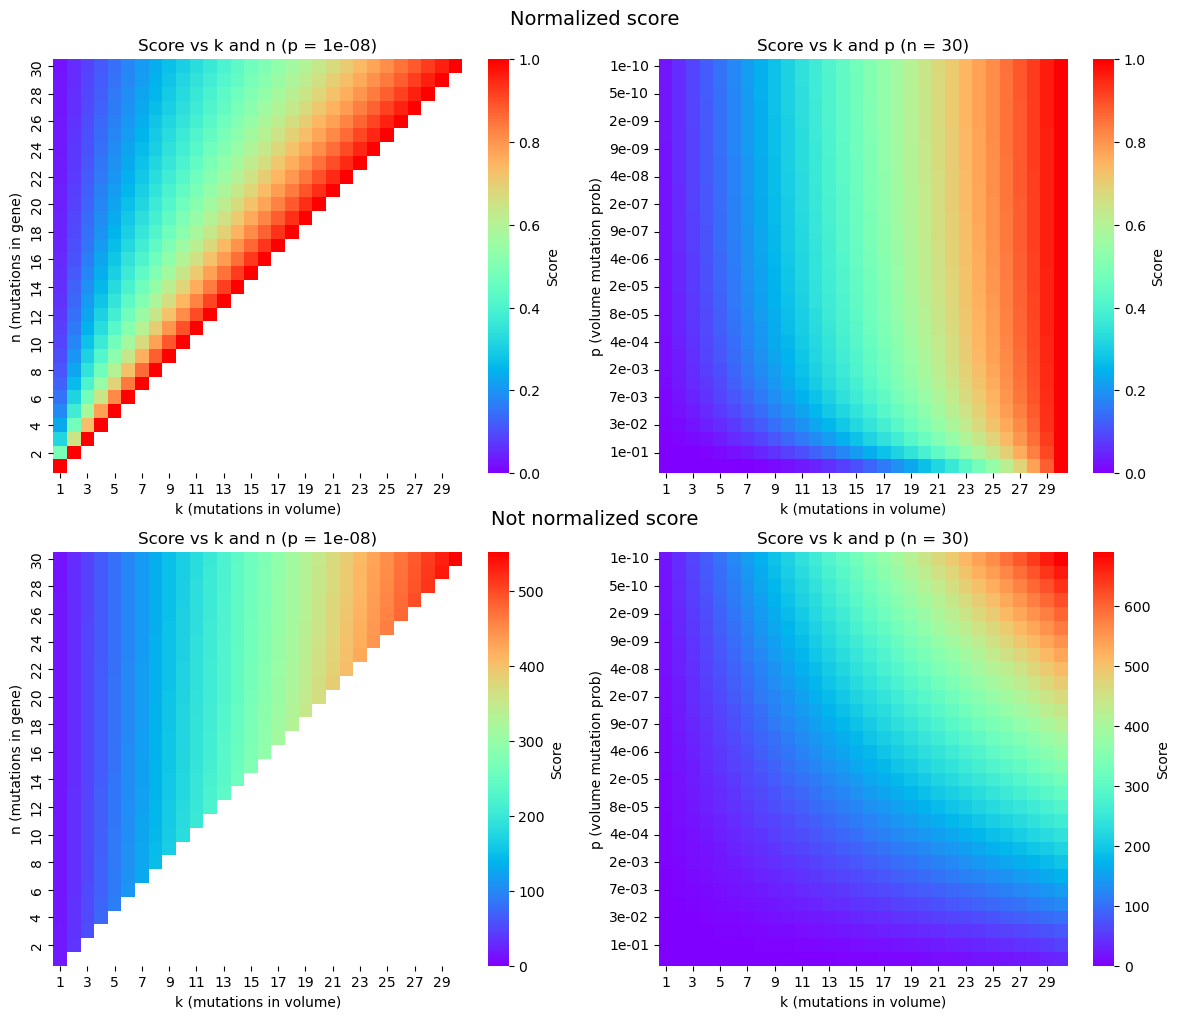

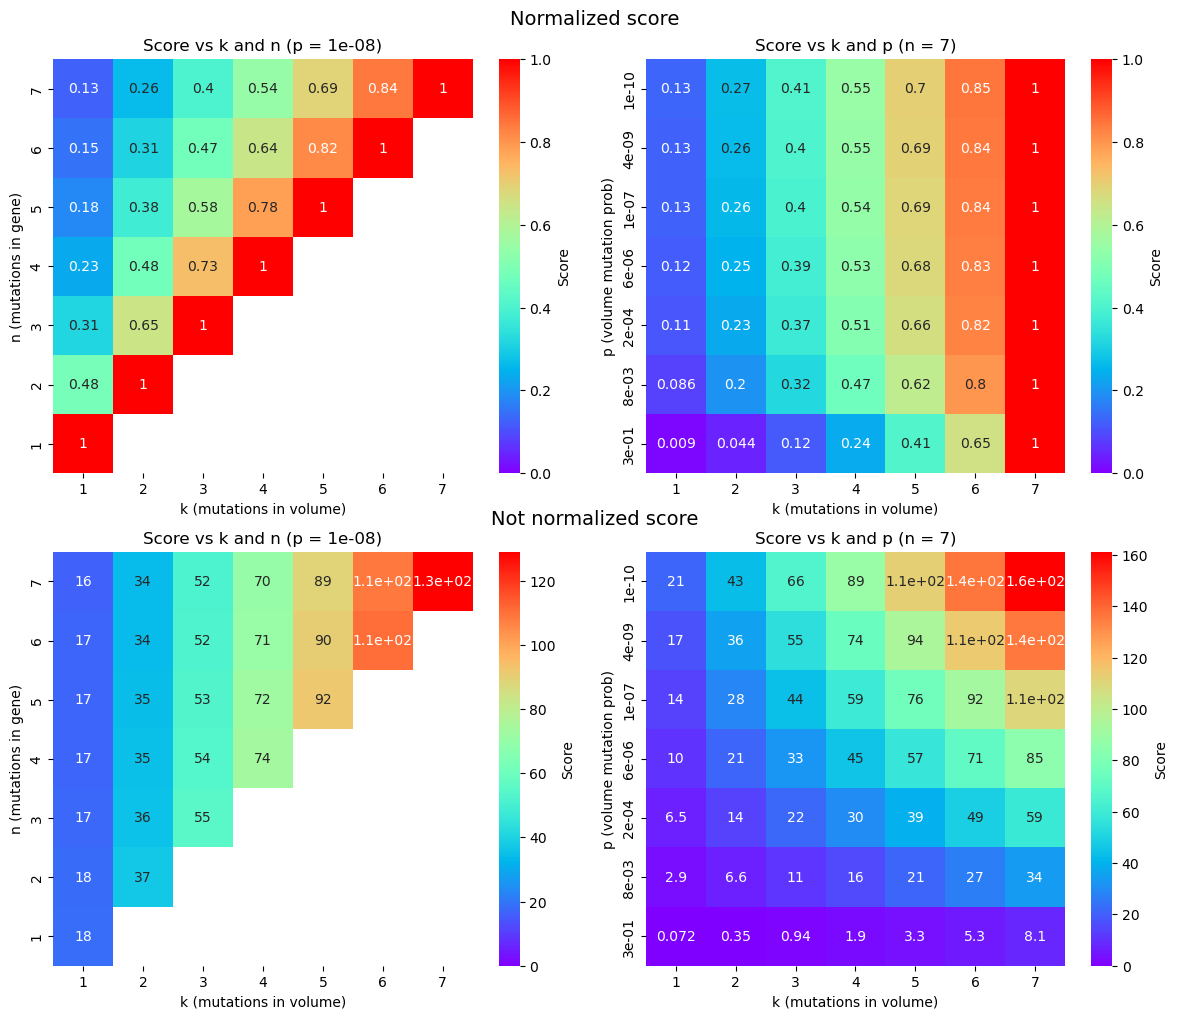

In [616]:
plot_score_comparison(n_points=30, n_fixed=30, p_fixed=1e-8, figsize=(12, 10))
plot_score_comparison(n_points=7, n_fixed=7, p_fixed=1e-8, figsize=(12, 10), annot=True)

## Notes
* We only compute p-values for genes with at least 2 mutations in the volume of any residue
* The pvalues of cohorts with 1000+ processed genes (N) seem to be well calibrated 
* There isn't an apparent correlation between sample size (number of processed genes and mutations) and deviation from neutrality